# Анализ лояльности пользователей Яндекс Афиши


## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<h1>🎯 Исследовательский анализ данных поведения пользователей</h1>

<h2>Введение</h2>

<p>
Команда маркетинга стремится лучше понимать поведение пользователей на платформе, чтобы повысить эффективность работы с клиентами и увеличить удержание. 
Для этого необходимо провести <strong>исследовательский анализ данных (EDA)</strong>, который поможет выявить закономерности в поведении пользователей, совершающих повторные заказы.
</p>

<h3>Цели проекта</h3>

<ul>
  <li>Определить, какие пользователи с большей вероятностью возвращаются на платформу и совершают повторные заказы.</li>
  <li>Выявить ключевые признаки, влияющие на возврат и повторную покупку (тип устройства, регион, тип мероприятия и др.).</li>
  <li>Сегментировать пользователей по уровню вовлечённости и частоте заказов.</li>
  <li>Создать базу для дальнейшего построения моделей прогнозирования возврата пользователей.</li>
</ul>

<h3>Задачи исследования</h3>

<ol>
  <li>Собрать и объединить данные о покупках, пользователях и мероприятиях.</li>
  <li>Рассчитать метрики, отражающие активность пользователей (количество заказов, выручка, интервал между покупками).</li>
  <li>Провести анализ распределений и зависимостей между показателями.</li>
  <li>Сформулировать гипотезы о факторах, влияющих на повторные заказы.</li>
</ol>

<h3>Ожидаемый результат</h3>

<p>
В результате анализа команда маркетинга получит <strong>аналитические инсайты</strong> о поведении пользователей, 
позволяющие:
</p>

<ul>
  <li>Быстро выявлять перспективных клиентов и предлагать им персонализированные предложения;</li>
  <li>Точнее настраивать рекламные кампании на аудитории с высокой вероятностью возврата;</li>
  <li>Оптимизировать маркетинговые бюджеты и повысить эффективность коммуникаций;</li>
  <li>Увеличить общий уровень удержания пользователей платформы.</li>
</ul>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import phik
from sqlalchemy import create_engine
import phik
from phik.report import plot_correlation_matrix

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'), 
    'host': os.getenv('DB_HOST'),
    'port': 6432,
    'db': os.getenv('DB_NAME')
}

In [4]:
engine = create_engine(
    f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
)

In [5]:
query = '''
select
	user_id,
	device_type_canonical,
	order_id,
	created_dt_msk as order_dt,
	created_ts_msk as order_ts,
	currency_code,
	revenue,
	tickets_count,
	DATE_PART(
        'day',
        created_dt_msk - lag(created_dt_msk) over (partition by user_id order by created_dt_msk)
    ) as days_since_prev,
	p.event_id,
	event_name_code as event_name,
	event_type_main,
	service_name,
	region_name,
	city_name
from
	afisha.purchases p
join afisha.events e on
	p.event_id = e.event_id
join afisha.city c on
	e.city_id = c.city_id
join afisha.regions r on
	c.region_id = r.region_id 
where
	device_type_canonical in ('mobile', 'desktop') and e.event_type_main <> 'фильм'
order by
	user_id,
	created_dt_msk
'''

In [6]:
df = pd.read_sql(query, con=engine)

In [7]:
df.head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---


In [8]:
df.shape

(290611, 15)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

<p>Вывод 1.2: Общая информация о данных</p>

<p>Выгрузка содержит <strong>290 611 строк</strong> и <strong>15 столбцов</strong>. Все данные были успешно загружены в df.</p>

<p>Первичный анализ</p>

<ul>
  <li>Количество строк совпадает с ожидаемым, пропусков почти нет, кроме поля <code>days_since_prev</code> (~21 933 пропусков), что логично для первой покупки пользователя.</li>
  <li>Типы данных в целом корректны: даты в datetime, числовые значения в float/int, текстовые поля в object.</li>
</ul>

<p>Рекомендуемые шаги предобработки</p>

<ul>
  <li>Проверить и, при необходимости, скорректировать тип данных <code>order_id</code> и <code>event_id</code> — иногда их удобно хранить как строки, чтобы избежать потери точности при больших числах.</li>
  <li>Обработать пропуски в <code>days_since_prev</code> (оставить <code>NaN</code> или заменить на 0 в зависимости от задач анализа).</li>
  <li>Проверить на дубликаты по <code>order_id</code> и <code>event_id</code>.</li>
  <li>Убедиться, что значения в категориальных столбцах (<code>device_type_canonical</code>, <code>currency_code</code>, <code>event_type_main</code>, <code>service_name</code>) корректны и нет опечаток.</li>
  <li>При необходимости создать категориальные типы (<code>category</code>) для экономии памяти и ускорения анализа.</li>
</ul>


---
###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:
---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [10]:
currency_df = pd.read_csv(r'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
currency_df.head(3)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


In [12]:
currency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [13]:
# преобразовать object на datetime
currency_df['data'] = pd.to_datetime(currency_df['data'])

In [14]:
# оставить нужные колонны
currency_df = currency_df[['data', 'curs']]

In [15]:
# добавить в df.
df = df.merge(currency_df, left_on='order_dt', right_on='data', how='left')

In [16]:
# создать столбец revenue_rub
df['revenue_rub'] = df['revenue']

In [17]:
# пересчитать kzt в rub
mask_kzt = df['currency_code'] == 'kzt'
df.loc[mask_kzt, 'revenue_rub'] = df.loc[mask_kzt, 'revenue'] * df.loc[mask_kzt, 'curs'] / 100

In [18]:
# удалить временные столбцы из объединения
df = df.drop(columns=['data', 'curs'])

In [19]:
df.head(2)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---


In [20]:
# 1. Проверка пропущенных значений
print("Пропуски в столбцах:")
print(df.isnull().sum())

Пропуски в столбцах:
user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64


In [21]:
# Проверим, что других пропусков нет
other_missing = df.drop(columns=['days_since_prev']).isnull().sum().sum()
print(f"Пропусков в остальных столбцах: {other_missing}")

Пропусков в остальных столбцах: 0


In [22]:
# Список всех столбцов с _id
id_cols = [col for col in df.columns if '_id' in col]

In [23]:
# Преобразуем их в строковый тип
for col in id_cols:
    df[col] = df[col].astype(str)

In [24]:
# Проверка
print(df[id_cols].dtypes)

user_id     object
order_id    object
event_id    object
dtype: object


In [25]:
# 2. Преобразование типов для экономии памяти
df['tickets_count'] = df['tickets_count'].astype('int16')
df['revenue_rub'] = df['revenue_rub'].astype('float32')
df['days_since_prev'] = df['days_since_prev'].astype('float32')

In [26]:
# Категориальные столбцы
cat_cols = ['device_type_canonical', 'currency_code',
            'event_name', 'event_type_main', 'service_name',
            'region_name', 'city_name']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [27]:
# 3. Проверка уникальных категорий и нормализация
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} уникальных значений")
    # Можно привести все строки к нижнему регистру для нормализации
    df[col] = df[col].str.lower() if df[col].dtype.name == 'category' else df[col]


device_type_canonical: 2 уникальных значений
currency_code: 2 уникальных значений
event_name: 15248 уникальных значений
event_type_main: 7 уникальных значений
service_name: 36 уникальных значений
region_name: 81 уникальных значений
city_name: 352 уникальных значений


In [28]:
# 4. Анализ распределения числовых данных
num_cols = ['revenue_rub', 'tickets_count', 'days_since_prev']
print(df[num_cols].describe())

         revenue_rub  tickets_count  days_since_prev
count  290611.000000  290611.000000    268678.000000
mean      555.572083       2.754311         3.222381
std       875.498169       1.170620        11.350510
min       -90.760002       1.000000         0.000000
25%       113.970001       2.000000         0.000000
50%       351.140015       3.000000         0.000000
75%       802.049988       4.000000         1.000000
max     81174.539062      57.000000       148.000000


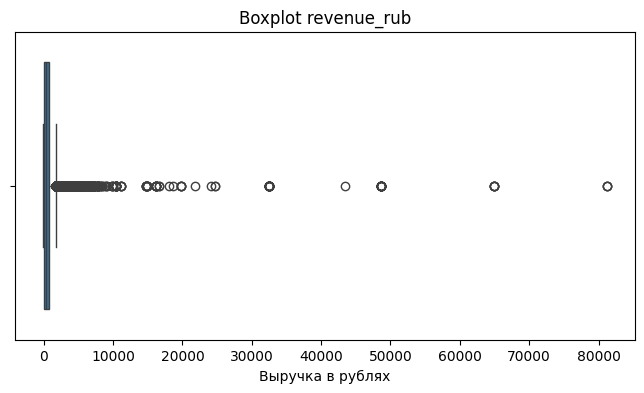

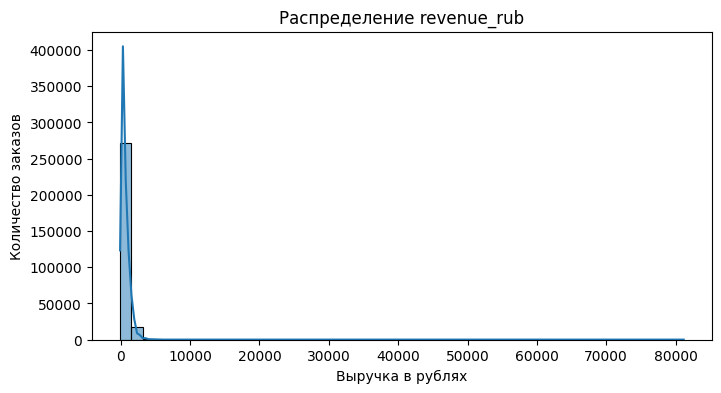

In [29]:
# Boxplot для revenue_rub

plt.figure(figsize=(8,4))
sns.boxplot(x=df['revenue_rub'])
plt.title('Boxplot revenue_rub')
plt.xlabel('Выручка в рублях')
plt.show()

# Гистограмма распределения revenue_rub 

plt.figure(figsize=(8,4))
sns.histplot(df['revenue_rub'], bins=50, kde=True)
plt.title('Распределение revenue_rub')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество заказов')
plt.show()

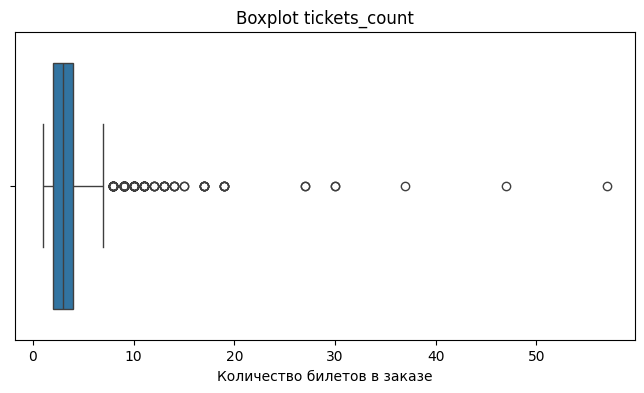

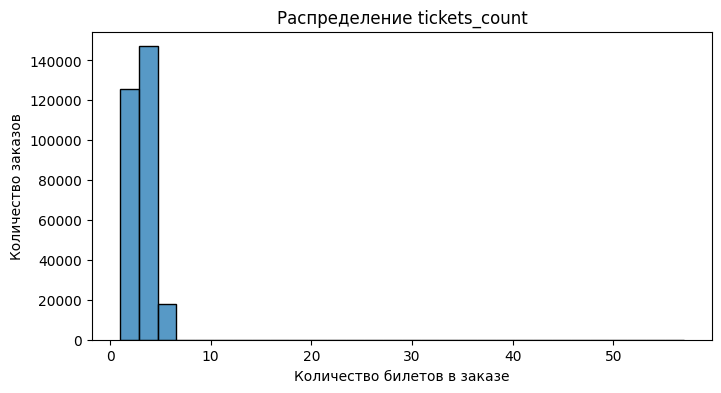

In [30]:
# Boxplot для tickets_count

plt.figure(figsize=(8,4))
sns.boxplot(x=df['tickets_count'])
plt.title('Boxplot tickets_count')
plt.xlabel('Количество билетов в заказе')
plt.show()

# Гистограмма распределения tickets_count

plt.figure(figsize=(8,4))
sns.histplot(df['tickets_count'], bins=30, kde=False)
plt.title('Распределение tickets_count')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')
plt.show()

In [31]:
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.572083,2.754311
std,875.498169,1.170620
min,-90.760002,1.000000
25%,113.970001,2.000000
50%,351.140015,3.000000
75%,802.049988,4.000000
max,81174.539062,57.000000


In [32]:
df[['revenue_rub', 'tickets_count']].agg(['min','max'])

,revenue_rub,tickets_count
min,-90.760002,1
max,81174.539062,57


revenue_rub:

Минимум: -90.76 → отрицательная выручка, что нереально, нужно исправить или удалить.
Максимум: 81 174.54 → явно выброс по сравнению с 75% квантилем (802.05).

Среднее: 555.57 → сильно смещено из-за выбросов.

tickets_count:

Минимум: 1 → ок
Максимум: 57 → редкие крупные заказы, выброс.
75% квантиль: 4 → большинство заказов до 4 билетов.


In [33]:
# Фильтруем revenue_rub и tickets_count по 99 перцентилю
revenue_99 = df['revenue_rub'].quantile(0.99)
tickets_99 = df['tickets_count'].quantile(0.99)

df_filtered = df[(df['revenue_rub'] <= revenue_99) & (df['tickets_count'] <= tickets_99)]

print("До фильтрации:", df.shape[0], "строк")
print("После фильтрации:", df_filtered.shape[0], "строк")

До фильтрации: 290611 строк
После фильтрации: 287606 строк


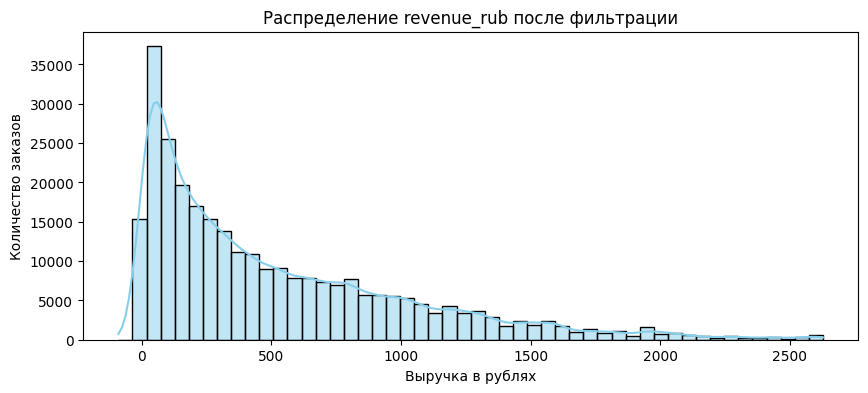

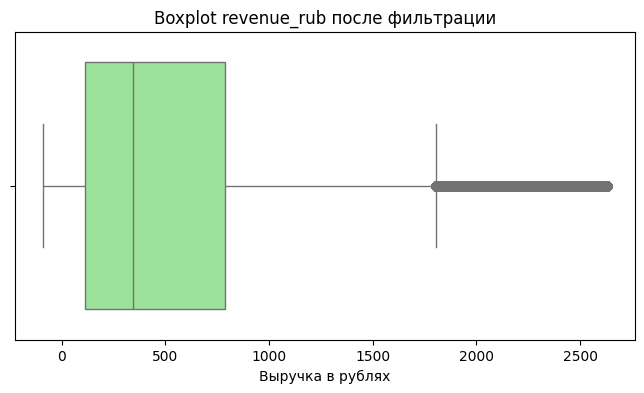

In [34]:
# Гистограмма для revenue_rub

plt.figure(figsize=(10,4))
sns.histplot(df_filtered['revenue_rub'], bins=50, kde=True, color='skyblue')
plt.title('Распределение revenue_rub после фильтрации')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество заказов')
plt.show()

# Boxplot для revenue_rub

plt.figure(figsize=(8,4))
sns.boxplot(x=df_filtered['revenue_rub'], color='lightgreen')
plt.title('Boxplot revenue_rub после фильтрации')
plt.xlabel('Выручка в рублях')
plt.show()

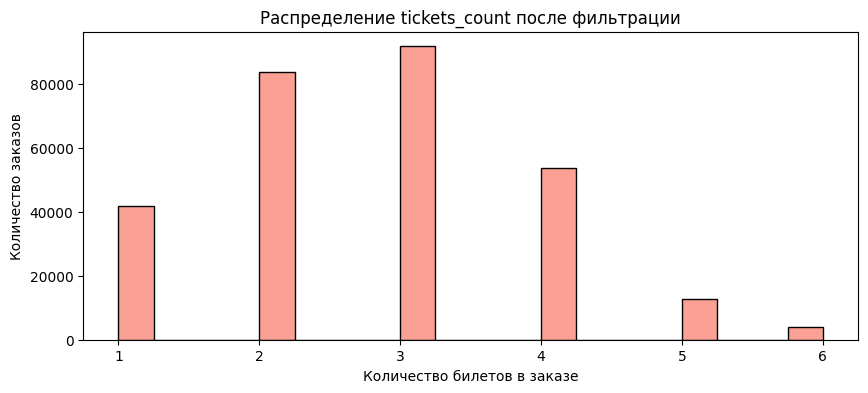

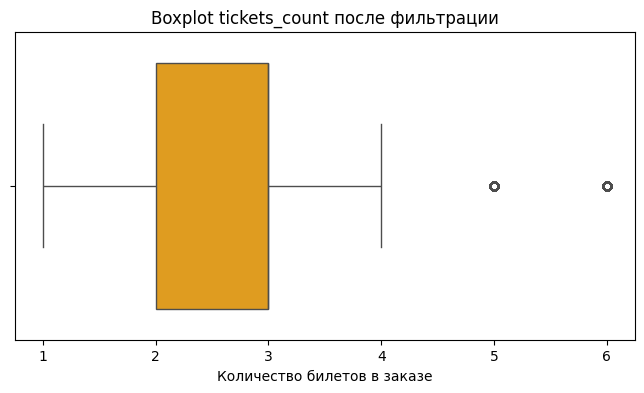

In [35]:
# Гистограмма для tickets_count

plt.figure(figsize=(10,4))
sns.histplot(df_filtered['tickets_count'], bins=20, kde=False, color='salmon')
plt.title('Распределение tickets_count после фильтрации')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')
plt.show()

# Boxplot для tickets_count

plt.figure(figsize=(8,4))
sns.boxplot(x=df_filtered['tickets_count'], color='orange')
plt.title('Boxplot tickets_count после фильтрации')
plt.xlabel('Количество билетов в заказе')
plt.show()

Промежуточный вывод

В данных есть пропуски только в days_since_prev → нормальная ситуация для первой покупки.

Были выбросы в revenue_rub (отрицательные и крайне большие значения) и в tickets_count (редкие очень большие заказы).

Применена фильтрация по 99 перцентилю → уменьшение влияния экстремальных значений на статистику.

Типы данных оптимизированы для экономии памяти и корректной работы анализа.

После фильтрации revenue_rub и tickets_count распределение стало более логичным и пригодным для дальнейшего анализа.


---
### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.
---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [36]:
# Сортируем по пользователю и дате заказа
df = df.sort_values(['user_id', 'order_dt'])

In [37]:
# --- 1. Данные первого заказа ---
first_orders = (
    df.groupby('user_id')
      .first()
      .reset_index()[['user_id', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']]
)
first_orders = first_orders.rename(columns={
    'device_type_canonical': 'first_device',
    'region_name': 'first_region',
    'service_name': 'first_partner',
    'event_type_main': 'first_genre'
})

In [38]:
# --- 2. Агрегаты по пользователю ---
user_profile = (
    df.groupby('user_id')
      .agg(
          first_order_dt=('order_dt', 'min'),
          last_order_dt=('order_dt', 'max'),
          orders_count=('order_id', 'count'),
          avg_revenue_rub=('revenue_rub', 'mean'),
          avg_tickets=('tickets_count', 'mean'),
          avg_days_between=('days_since_prev', 'mean')
      )
      .reset_index()
)

In [39]:
# --- 3. Присоединяем данные первого заказа ---
user_profile = user_profile.merge(first_orders, on='user_id', how='left')

In [40]:
# --- 4. Добавляем бинарные признаки ---
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int)

In [41]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,orders_count,avg_revenue_rub,avg_tickets,avg_days_between,first_device,first_region,first_partner,first_genre,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN,mobile,каменевский регион,край билетов,театр,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0,mobile,каменевский регион,мой билет,выставки,1,0
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0,mobile,североярская область,лови билет!,другое,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN,desktop,каменевский регион,край билетов,театр,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0,mobile,поленовский край,лучшие билеты,театр,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.


In [42]:
# Общее число пользователей
total_users = user_profile['user_id'].nunique()

# Средняя выручка с одного заказа (по всем заказам)
avg_revenue_per_order = df['revenue_rub'].mean()

# Доля пользователей с >=2 заказами и >=5 заказами
share_two_plus = user_profile['is_two'].mean()
share_five_plus = user_profile['is_five'].mean()

print(f'Общее число пользователей: {total_users}')
print(f'Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.')
print(f'Доля пользователей с >=2 заказами: {share_two_plus:.2%}')
print(f'Доля пользователей с >=5 заказами: {share_five_plus:.2%}')

Общее число пользователей: 21933
Средняя выручка с одного заказа: 555.57 руб.
Доля пользователей с >=2 заказами: 61.82%
Доля пользователей с >=5 заказами: 29.18%


In [43]:
# Статистика по заказам, билетам и интервалам между заказами
stats = user_profile[['orders_count', 'avg_tickets', 'avg_days_between']].describe()
print(stats)

       orders_count   avg_tickets  avg_days_between
count  21933.000000  21933.000000      13559.000000
mean      13.249943      2.755987         15.808537
std      122.470535      0.920739         22.249582
min        1.000000      1.000000          0.000000
25%        1.000000      2.000000          1.000000
50%        2.000000      2.764151          8.000000
75%        5.000000      3.125000         20.400000
max    10251.000000     12.000000        148.000000


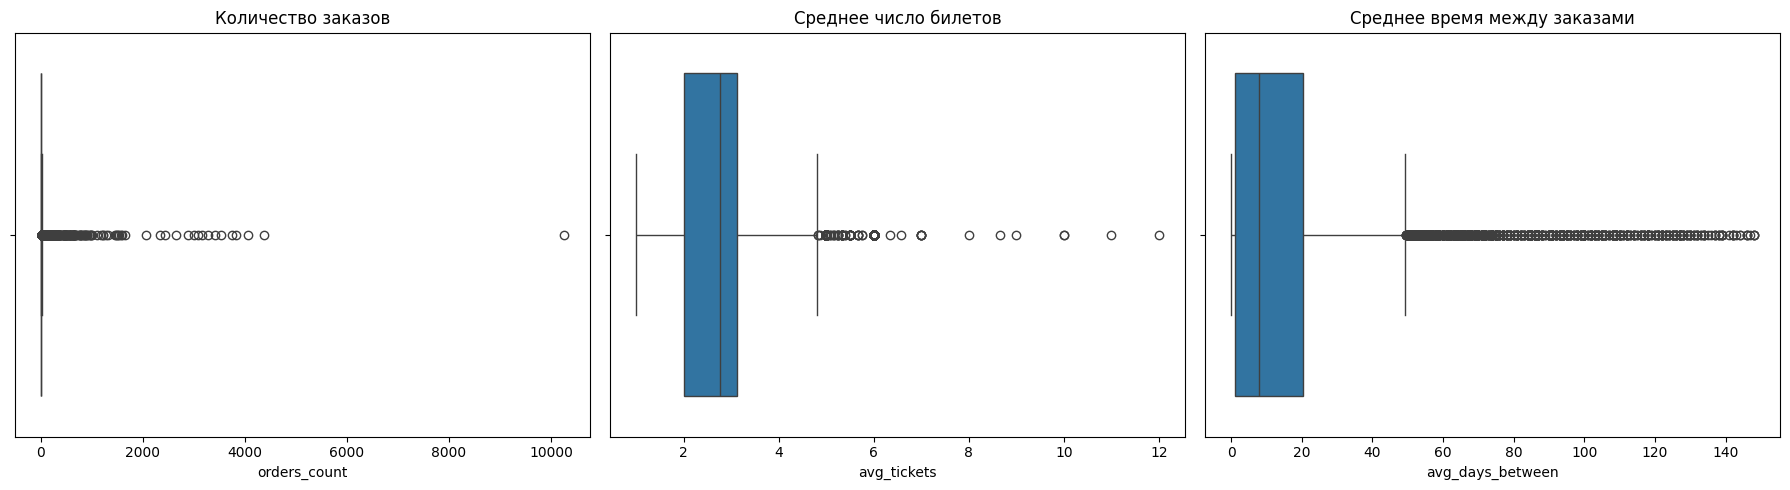

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x=user_profile['orders_count'], ax=axes[0])
axes[0].set_title('Количество заказов')

sns.boxplot(x=user_profile['avg_tickets'], ax=axes[1])
axes[1].set_title('Среднее число билетов')

sns.boxplot(x=user_profile['avg_days_between'], ax=axes[2])
axes[2].set_title('Среднее время между заказами')

plt.tight_layout()
plt.show()

In [45]:
# Вычисляем порог 99-го перцентиля
orders_threshold = user_profile['orders_count'].quantile(0.99)
tickets_threshold = user_profile['avg_tickets'].quantile(0.99)

print(f"Порог 99 перцентиля по заказам: {orders_threshold}")
print(f"Порог 99 перцентиля по билетам: {tickets_threshold}")

# Отфильтровываем пользователей с экстремальными значениями
filtered_profile = user_profile[
    (user_profile['orders_count'] <= orders_threshold) &
    (user_profile['avg_tickets'] <= tickets_threshold)
]

Порог 99 перцентиля по заказам: 152.0
Порог 99 перцентиля по билетам: 5.0


In [46]:
removed = len(user_profile) - len(filtered_profile)
print(f'Удалено пользователей: {removed} ({removed / len(user_profile):.2%})')

filtered_profile[['orders_count', 'avg_tickets', 'avg_days_between']].describe()

Удалено пользователей: 428 (1.95%)


,orders_count,avg_tickets,avg_days_between
count,21505.000000,21505.000000,13272.000000
mean,6.567589,2.724418,16.110468
std,14.396778,0.867993,22.357216
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.372727
50%,2.000000,2.750000,8.444445
75%,5.000000,3.090909,20.839287
max,152.000000,5.000000,148.000000


После фильтрации аномальных значений по 99-му перцентилю из датасета было удалено:
428 пользователей (1.95%)
Такой объём удаления несущественный, следовательно, фильтрация не искажает общую картину и улучшает качество данных.
Количество заказов.
Медиана равна 2, что говорит о том, что половина пользователей делает не более двух заказов.
Однако среднее значение 6.6 и большое стандартное отклонение (14.4) указывают на небольшую группу очень активных пользователей.

Количество билетов.
Большинство заказов включает от 2 до 3 билетов, что выглядит реалистично (например, покупки для пары или небольшой компании).

Интервалы между покупками.
Средний промежуток — 16 дней, но медиана ниже (около 8 дней), что говорит о сильной асимметрии: часть пользователей возвращается быстро, а часть — делает редкие покупки.


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.


#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
  - по типу их первого мероприятия;
  - по типу устройства, с которого совершена первая покупка;
  - по региону проведения мероприятия из первого заказа;
  - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [47]:
# Функция для анализа распределения по категориальному признаку
def analyze_distribution(df, column_name, top_n=None):
    segment = (
        df.groupby(column_name)
        .agg(users_count=('user_id', 'count'))
        .reset_index()
        .sort_values(by='users_count', ascending=False)
    )
    segment['users_share_%'] = (segment['users_count'] / len(df) * 100).round(2)

    if top_n:
        display(segment.head(top_n))
    else:
        display(segment)

    print(f"\nВсего пользователей: {len(df)}")
    print(f"Количество уникальных категорий в '{column_name}': {segment[column_name].nunique()}")
    print(f"Самая популярная категория: {segment.iloc[0][column_name]} ({segment.iloc[0]['users_share_%']}%)")

# Распределение по типу первого мероприятия
print("Распределение по типу первого мероприятия (first_genre):")
analyze_distribution(user_profile, 'first_genre')

# Распределение по типу устройства первого заказа
print("\nРаспределение по типу устройства первого заказа (first_device):")
analyze_distribution(user_profile, 'first_device')

# Распределение по региону первого заказа
print("\nРаспределение по региону первого заказа (first_region):")
analyze_distribution(user_profile, 'first_region', top_n=10)

# Распределение по билетному оператору первого заказа
print("\nРаспределение по билетному оператору первого заказа (first_partner):")
analyze_distribution(user_profile, 'first_partner', top_n=10)

Распределение по типу первого мероприятия (first_genre):


,first_genre,users_count,users_share_%
2,концерты,9711,44.28
1,другое,5481,24.99
5,театр,4312,19.66
4,стендап,1126,5.13
3,спорт,803,3.66
0,выставки,406,1.85
6,ёлки,94,0.43



Всего пользователей: 21933
Количество уникальных категорий в 'first_genre': 7
Самая популярная категория: концерты (44.28%)

Распределение по типу устройства первого заказа (first_device):


,first_device,users_count,users_share_%
1,mobile,18132,82.67
0,desktop,3801,17.33



Всего пользователей: 21933
Количество уникальных категорий в 'first_device': 2
Самая популярная категория: mobile (82.67%)

Распределение по региону первого заказа (first_region):


,first_region,users_count,users_share_%
23,каменевский регион,7210,32.87
60,североярская область,3794,17.30
77,широковская область,1249,5.69
45,озернинский край,677,3.09
41,малиновоярский округ,531,2.42
76,шанырский регион,505,2.30
74,травяная область,494,2.25
57,светополянский округ,469,2.14
52,речиновская область,442,2.02
78,яблоневская область,416,1.90



Всего пользователей: 21933
Количество уникальных категорий в 'first_region': 81
Самая популярная категория: каменевский регион (32.87%)

Распределение по билетному оператору первого заказа (first_partner):


,first_partner,users_count,users_share_%
3,билеты без проблем,5225,23.82
22,мой билет,3025,13.79
19,лови билет!,2858,13.03
4,билеты в руки,2584,11.78
23,облачко,2197,10.02
7,весь в билетах,1324,6.04
20,лучшие билеты,1188,5.42
24,прачечная,582,2.65
17,край билетов,465,2.12
12,дом культуры,347,1.58



Всего пользователей: 21933
Количество уникальных категорий в 'first_partner': 34
Самая популярная категория: билеты без проблем (23.82%)


Пользователи распределены неравномерно, есть явные точки входа:

Концерты, mobile, Каменевский регион, «Билеты без проблем».

Эти сегменты формируют ядро пользователей, на них маркетинг может ориентироваться при персонализации и ретаргетинге.


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [48]:
# Функция для расчёта количества пользователей и доли возвратных
def segment_return_rate(df, segment_col):
    segment_stats = (
        df.groupby(segment_col)
          .agg(users_count=('user_id', 'count'),
               returning_share=('is_two', 'mean'))  # mean по бинарной колонке = доля
          .reset_index()
    )
    segment_stats['returning_share'] = segment_stats['returning_share'] * 100  # %
    segment_stats = segment_stats.sort_values('users_count', ascending=False)
    return segment_stats

In [49]:
# 1. Первый жанр
genre_stats = segment_return_rate(user_profile, 'first_genre')

# 2. Тип устройства
device_stats = segment_return_rate(user_profile, 'first_device')

# 3. Регион (топ-10)
region_stats = segment_return_rate(user_profile, 'first_region').head(10)

# 4. Партнёр (топ-10)
partner_stats = segment_return_rate(user_profile, 'first_partner').head(10)

C:\Users\admin\AppData\Local\Temp\ipykernel_12836\2450067935.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_12836\2450067935.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_12836\2450067935.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_12836\2450067935.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hu

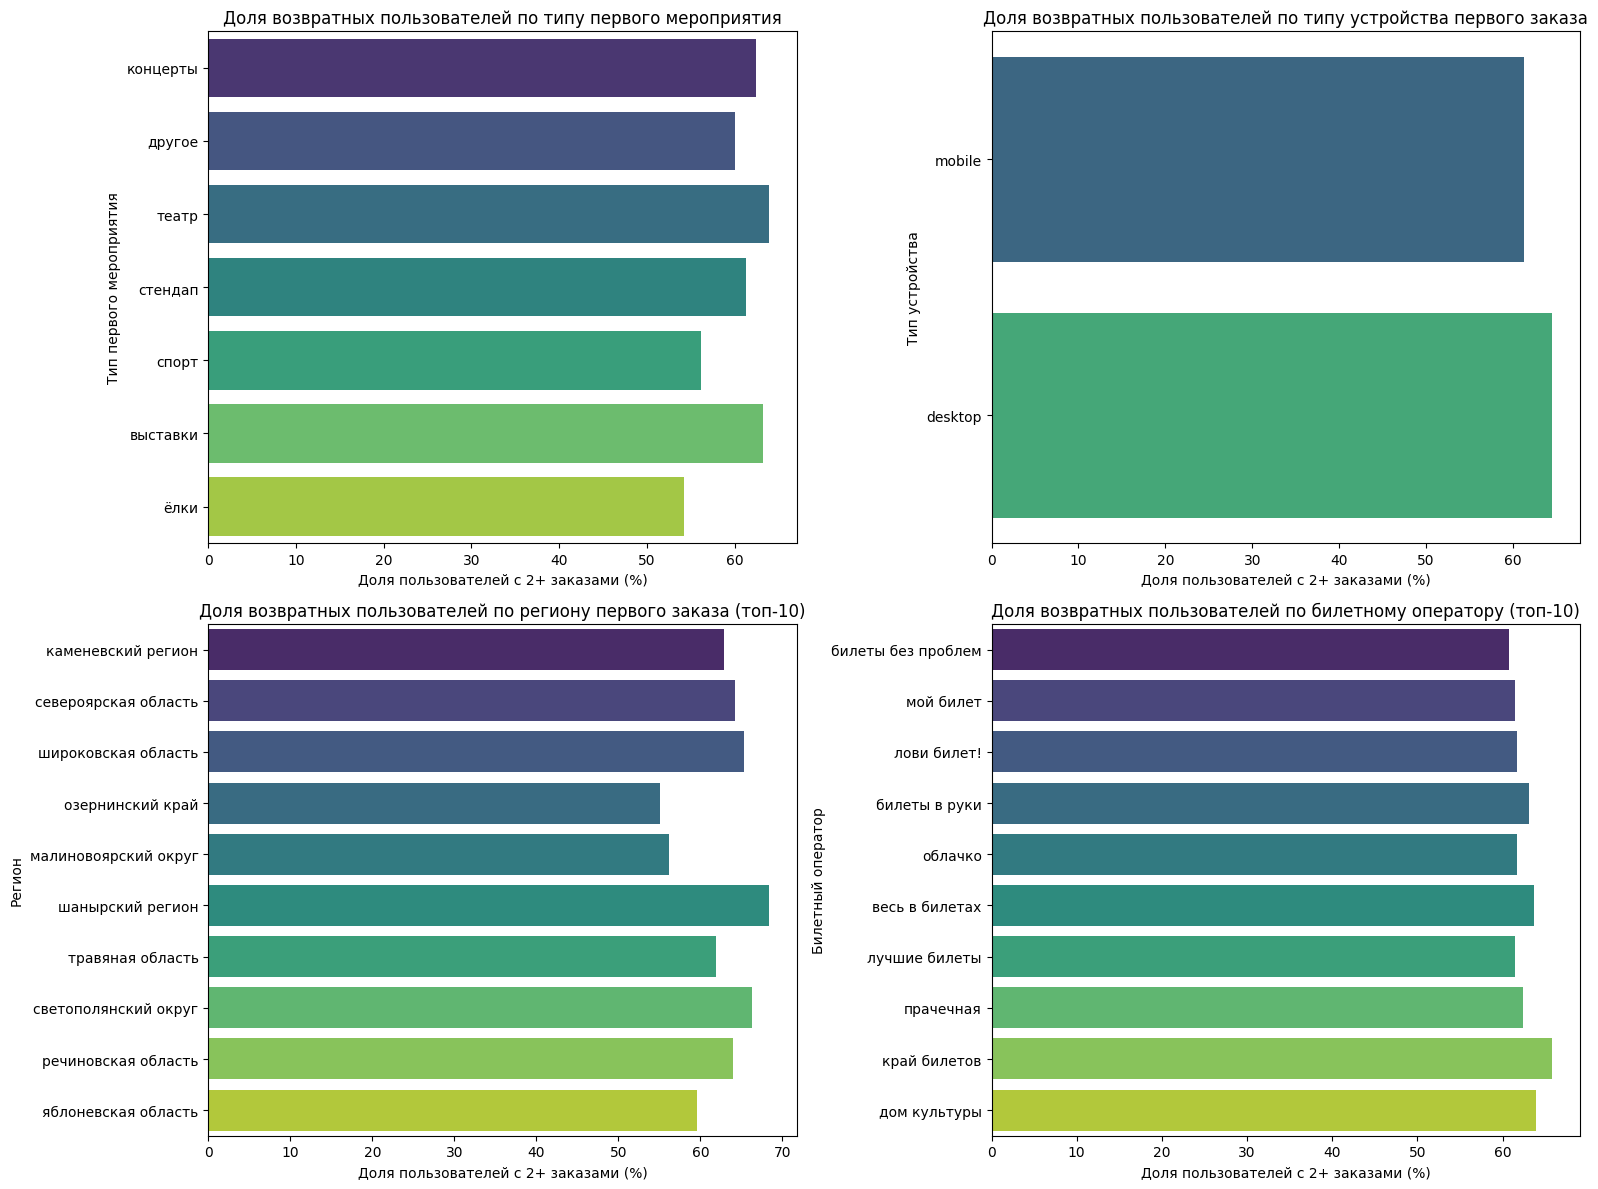

In [50]:
# --- Построение графиков ---
fig, axes = plt.subplots(2,2, figsize=(16,12))

# Первый жанр
sns.barplot(
    data=genre_stats, y='first_genre', x='returning_share', palette='viridis', ax=axes[0,0]
)
axes[0,0].set_title('Доля возвратных пользователей по типу первого мероприятия')
axes[0,0].set_xlabel('Доля пользователей с 2+ заказами (%)')
axes[0,0].set_ylabel('Тип первого мероприятия')

# Тип устройства
sns.barplot(
    data=device_stats, y='first_device', x='returning_share', palette='viridis', ax=axes[0,1]
)
axes[0,1].set_title('Доля возвратных пользователей по типу устройства первого заказа')
axes[0,1].set_xlabel('Доля пользователей с 2+ заказами (%)')
axes[0,1].set_ylabel('Тип устройства')

# Регион
sns.barplot(
    data=region_stats, y='first_region', x='returning_share', palette='viridis', ax=axes[1,0]
)
axes[1,0].set_title('Доля возвратных пользователей по региону первого заказа (топ-10)')
axes[1,0].set_xlabel('Доля пользователей с 2+ заказами (%)')
axes[1,0].set_ylabel('Регион')

# Партнёр
sns.barplot(
    data=partner_stats, y='first_partner', x='returning_share', palette='viridis', ax=axes[1,1]
)
axes[1,1].set_title('Доля возвратных пользователей по билетному оператору (топ-10)')
axes[1,1].set_xlabel('Доля пользователей с 2+ заказами (%)')
axes[1,1].set_ylabel('Билетный оператор')

plt.tight_layout()
plt.show()

In [51]:
# Средняя доля возвратных пользователей по всей выборке
overall_share = user_profile['is_two'].mean() * 100
print(f'Средняя доля пользователей с 2+ заказами: {overall_share:.2f}%')

Средняя доля пользователей с 2+ заказами: 61.82%


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---


In [52]:
# --- Гипотеза 1: по жанрам первого мероприятия
genre_summary = (
    user_profile
    .groupby('first_genre')
    .agg(
        users_count=('user_id', 'count'),
        repeat_rate=('is_two', 'mean')  # доля пользователей с 2 и более заказами
    )
    .reset_index()
    .sort_values(by='users_count', ascending=False)
)

print("Агрегированные данные по жанрам:")
print(genre_summary)

# --- Гипотеза 2: по региону первого заказа
region_summary = (
    user_profile
    .groupby('first_region')
    .agg(
        users_count=('user_id', 'count'),
        repeat_rate=('is_two', 'mean')
    )
    .reset_index()
    .sort_values(by='users_count', ascending=False)
)

print("\nАгрегированные данные по регионам:")
print(region_summary)


Агрегированные данные по жанрам:
  first_genre  users_count  repeat_rate
2    концерты         9711     0.624344
1      другое         5481     0.600620
5       театр         4312     0.638915
4     стендап         1126     0.612789
3       спорт          803     0.561644
0    выставки          406     0.633005
6        ёлки           94     0.542553

Агрегированные данные по регионам:
                 first_region  users_count  repeat_rate
23         каменевский регион         7210     0.628571
60       североярская область         3794     0.642330
77        широковская область         1249     0.652522
45           озернинский край          677     0.550960
41       малиновоярский округ          531     0.561205
76           шанырский регион          505     0.683168
74           травяная область          494     0.619433
57       светополянский округ          469     0.663113
52        речиновская область          442     0.640271
78        яблоневская область          416     0.59

Гипотеза 1: Тип первого мероприятия и вероятность возврата

Доля пользователей с 2 и более заказами (repeat_rate) по жанрам:

Театр: 63.9%

Выставки: 63.3%

Концерты: 62.4%

Другое: 60.1%

Стендап: 61.3%

Спорт: 56.2%

Ёлки: 54.3%

Вывод: пользователи, начавшие с спорта или ёлок, возвращаются реже среднего.
Пользователи, начавшие с театра, выставок или концертов, возвращаются чаще.
Гипотеза о том, что «спорт возвращает чаще, чем концерты» — не подтверждается.

Гипотеза 2: Регион и вероятность возврата

Сегменты с наибольшей долей возвратов:

Озернопольская область — 88.9%

Радужнопольский край — 78.3%

Горноземский регион — 68.9%

Шанырский регион — 68.3%

Светополянский округ — 66.3%

Сегменты с наибольшим количеством пользователей:

Каменевский регион — 32.87% пользователей, 62.9% возвратов

Североярская область — 17.3% пользователей, 64.2% возвратов

Широковская область — 5.69% пользователей, 65.3% возвратов

Вывод:

В регионах с большим числом пользователей (Каменевский, Североярская, Широковская) доля возвратов чуть выше среднего, но не максимально возможная.

Самые высокие доли возвратов наблюдаются в регионах с малым числом пользователей (меньше 30–50 человек), что может быть статистически нестабильно.

Вывод по гипотезе: регионы с большим числом пользователей не всегда показывают максимальный возврат, но в среднем возврат чуть выше среднего. Высокие показатели в маленьких регионах — аномалия из-за малой выборки.


---
#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.
---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
  - для пользователей, совершивших один заказ;
  - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
  - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
  - Есть ли различия между группами?

Текст на сером фоне:

**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


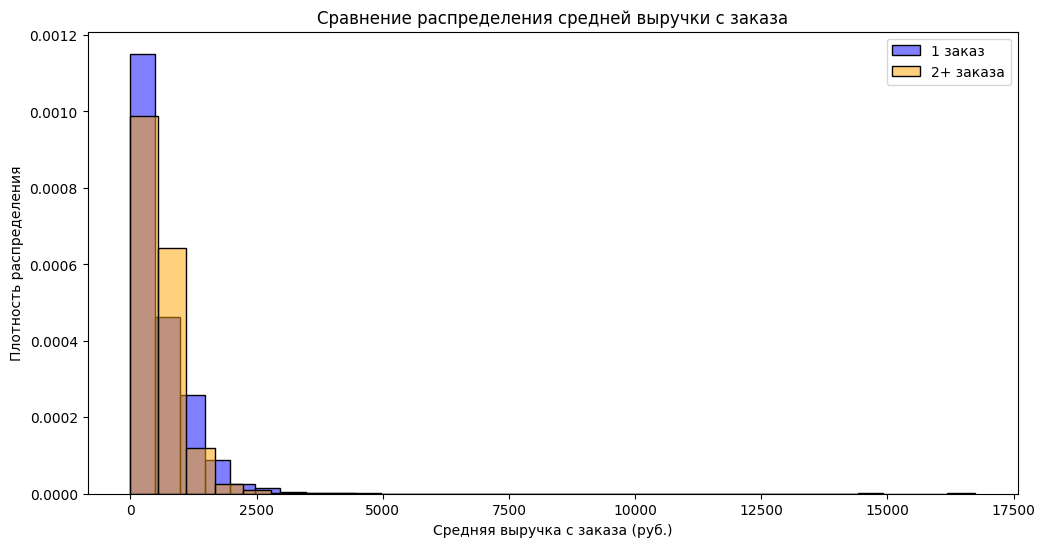

In [53]:
# Разделяем пользователей на две группы
one_order_users = user_profile[user_profile['is_two'] == 0]
repeat_users = user_profile[user_profile['is_two'] == 1]

# Параметры гистограмм
bins = 30
alpha = 0.5

plt.figure(figsize=(12,6))

# Гистограмма для пользователей с 1 заказом
sns.histplot(one_order_users['avg_revenue_rub'], bins=bins, color='blue', alpha=alpha, label='1 заказ', kde=False, stat='density')

# Гистограмма для вернувшихся пользователей
sns.histplot(repeat_users['avg_revenue_rub'], bins=bins, color='orange', alpha=alpha, label='2+ заказа', kde=False, stat='density')

plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки с заказа')
plt.legend()
plt.show()


1. Диапазоны концентрации пользователей:
   Группа с 1 заказом (is_two = 0):

Основная концентрация: 133-840 руб. (25%-75% перцентили)

Типичный диапазон: 39-1305 руб. (10%-90% перцентили)

Медиана: 381 руб.

Группа с 2+ заказами (is_two = 1):

Основная концентрация: 278-764 руб. (25%-75% перцентили)

Типичный диапазон: 108-1073 руб. (10%-90% перцентили)

Медиана: 509 руб.

2. Различия между группами:
   Статистически значимые различия есть:

Ключевые отличия:

Сдвиг распределения вправо у повторных пользователей:

Медиана выше на 34% (381 руб. vs 509 руб.)

25-й перцентиль выше в 2 раза (133 руб. vs 278 руб.)

Более узкий разброс у повторных пользователей:

Стандартное отклонение: 508 руб. vs 629 руб.

Разница между 10% и 90%: 966 руб. vs 965 руб. (при том что медиана выше)

Меньше экстремальных значений у повторных пользователей:

95-й перцентиль: 1609 руб. vs 1323 руб.

99-й перцентиль: 2576 руб. vs 2076 руб.

Выводы:
Повторные пользователи (2+ заказа):

Более "качественные" и стабильные по расходам

Меньше очень дешевых заказов (минимальные заказы дороже)

Меньше экстремально дорогих заказов

Концентрируются в среднем ценовом сегменте

Пользователи с 1 заказом:

Более широкий разброс по выручке

Больше как очень дешевых, так и очень дорогих заказов

В целом склонны тратить меньше

Это говорит о том, что пользователи, которые делают повторные покупки, более предсказуемы в своих расходах и в среднем тратят больше.


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


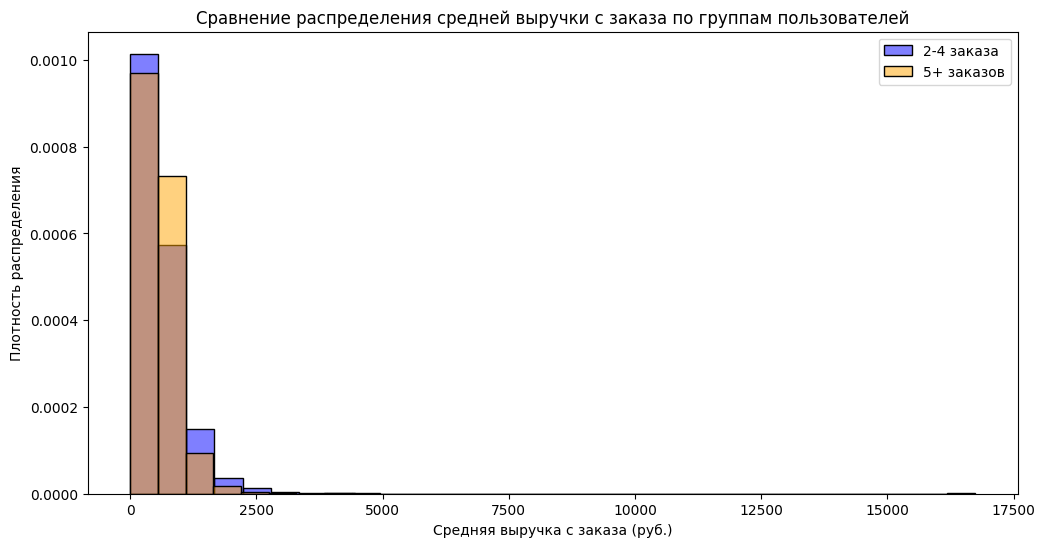

In [54]:
# Создаём группы по числу заказов
user_profile['order_group'] = user_profile['orders_count'].apply(
    lambda x: '2-4 заказа' if 2 <= x <= 4 else ('5+ заказов' if x >= 5 else '1 заказ')
)

# Фильтруем только группы с 2+ заказами
df_orders = user_profile[user_profile['order_group'].isin(['2-4 заказа', '5+ заказов'])]

# Параметры гистограммы
bins = 30
alpha = 0.5

plt.figure(figsize=(12,6))

# Гистограмма для пользователей с 2-4 заказами
sns.histplot(
    df_orders[df_orders['order_group'] == '2-4 заказа']['avg_revenue_rub'],
    bins=bins,
    color='blue',
    alpha=alpha,
    stat='density',
    label='2-4 заказа'
)

# Гистограмма для пользователей с 5+ заказами
sns.histplot(
    df_orders[df_orders['order_group'] == '5+ заказов']['avg_revenue_rub'],
    bins=bins,
    color='orange',
    alpha=alpha,
    stat='density',
    label='5+ заказов'
)

plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки с заказа по группам пользователей')
plt.legend()
plt.show()


Сравнение групп "2-4 заказа" vs "5+ заказов"
Ключевые наблюдения:
Сходства:

Средняя выручка практически идентична: 580.63 руб. vs 576.25 руб. (разница всего 0.8%)

Общий характер распределения сохраняется

Различия:

Более стабильное поведение у "ветеранов" (5+ заказов):

Стандартное отклонение: 431 руб. vs 568 руб. (на 24% меньше)

Меньше разброс в расходах

Сдвиг в сторону более дорогих заказов у "постоянных клиентов":

25-й перцентиль: 346 руб. vs 219 руб. (на 58% выше)

10-й перцентиль: 165 руб. vs 79 руб. (в 2 раза выше)

Медиана: 528 руб. vs 476 руб. (на 11% выше)

Меньше экстремальных значений у "ветеранов":

90-й перцентиль: 983 руб. vs 1159 руб. (на 15% ниже)

95-й перцентиль: 1173 руб. vs 1441 руб. (на 19% ниже)

99-й перцентиль: 1846 руб. vs 2246 руб. (на 18% ниже)

Вывод:
Различия есть, но они качественные, а не количественные по средней выручке

Группа "2-4 заказа":

Более широкий разброс по выручке

Больше как очень дешевых, так и очень дорогих заказов

Более "рисковое" поведение

Группа "5+ заказов":

Более консервативные и предсказуемые расходы

Меньше экстремальных значений (как низких, так и высоких)

Концентрируются в среднем ценовом сегменте (346-727 руб.)

Итог: С ростом лояльности пользователи становятся более стабильными в своих расходах, отсеиваются крайние значения, но средний чек практически не меняется.


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---


In [55]:
# Создаём сегменты по среднему количеству билетов
bins = [0, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profile['tickets_segment'] = pd.cut(user_profile['avg_tickets'], bins=bins, labels=labels, right=False)

# Агрегируем данные по сегментам
segment_stats = user_profile.groupby('tickets_segment').agg(
    users_count=('user_id', 'count'),
    repeat_rate=('is_two', 'mean')  # доля пользователей с 2 и более заказами
).reset_index()

# Добавляем колонку с долей пользователей в процентах
segment_stats['users_share_%'] = 100 * segment_stats['users_count'] / segment_stats['users_count'].sum()

# Сортировка по сегментам для удобства
segment_stats = segment_stats.sort_index()

print(segment_stats)

  tickets_segment  users_count  repeat_rate  users_share_%
0      1-2 билета         2401     0.511870      10.946975
1      2-3 билета         9642     0.741029      43.961154
2     3-5 билетов         9201     0.549071      41.950486
3      5+ билетов          689     0.193033       3.141385


C:\Users\admin\AppData\Local\Temp\ipykernel_12836\4068552469.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = user_profile.groupby('tickets_segment').agg(


1. Распределение пользователей по сегментам:

Наибольшее количество пользователей сосредоточено в сегментах 2–3 билета (43.96%) и 3–5 билетов (41.95%), то есть почти 85% всех пользователей покупают в среднем 2–5 билетов за заказ.

Сегмент 1–2 билета содержит около 11% пользователей.

Сегмент 5+ билетов крайне мал — всего 3.14% пользователей.

Вывод: распределение неравномерное, оно сильно сконцентрировано в среднем диапазоне 2–5 билетов. Малые сегменты на крайних значениях (1–2 билета и 5+) составляют меньшую долю пользователей.

2. Доля повторных заказов (repeat_rate):

Сегмент 2–3 билета имеет наибольшую долю повторных пользователей — 74%, что говорит о высокой вовлеченности.

Сегмент 3–5 билетов — около 55% повторных пользователей, что ниже среднего по выборке.

Сегмент 1–2 билета — около 51%, чуть выше случайного уровня, но ниже сегмента 2–3.

Сегмент 5+ билетов — всего 19%, что аномально низко. Пользователи с очень крупными заказами редко возвращаются.

Интерпретация:

Пользователи с умеренными заказами (2–3 билета) чаще возвращаются.

Очень крупные заказы (5+ билетов) могут быть разовыми событиями, например, корпоративные покупки или подарочные наборы, что объясняет низкий процент повторных покупок.


---
#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:
  - день недели первой покупки;
  - время с момента первой покупки — лайфтайм;
  - средний интервал между покупками пользователей с повторными заказами.
---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [56]:
# Создаем копию данных для анализа
analysis_data = user_profile[['user_id', 'first_order_dt', 'orders_count', 'is_two']].copy()

# 1. Извлекаем день недели из даты первого заказа
analysis_data['first_order_weekday'] = analysis_data['first_order_dt'].dt.day_name()

# 2. Группируем по дням недели и считаем метрики
weekday_analysis = analysis_data.groupby('first_order_weekday').agg({
    'user_id': 'count',
    'is_two': 'sum',
    'orders_count': 'mean'
}).reset_index()

# 3. Рассчитываем долю вернувшихся пользователей
weekday_analysis['repeat_rate'] = (weekday_analysis['is_two'] / weekday_analysis['user_id'] * 100).round(2)
weekday_analysis['total_users'] = weekday_analysis['user_id']

# 4. Сортируем по порядку дней недели (для красивого отображения)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_analysis['first_order_weekday'] = pd.Categorical(weekday_analysis['first_order_weekday'], categories=days_order, ordered=True)
weekday_analysis = weekday_analysis.sort_values('first_order_weekday')

# 5. Выводим результаты
print("Анализ влияния дня недели первой покупки:")
print(weekday_analysis[['first_order_weekday', 'total_users', 'is_two', 'repeat_rate', 'orders_count']].round(2))

# 6. Дополнительно: проверка статистической значимости
from scipy.stats import chi2_contingency

# Создаем таблицу сопряженности
contingency_table = pd.crosstab(analysis_data['first_order_weekday'], analysis_data['is_two'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nПроверка статистической значимости:")
print(f"Chi-square p-value: {p_value:.4f}")

Анализ влияния дня недели первой покупки:
  first_order_weekday  total_users  is_two  repeat_rate  orders_count
1              Monday         2947    1868        63.39          7.89
5             Tuesday         3218    2010        62.46          8.05
6           Wednesday         3084    1927        62.48          6.88
4            Thursday         3130    1865        59.58          6.03
0              Friday         3274    1962        59.93          5.52
2            Saturday         3461    2219        64.11         43.68
3              Sunday         2819    1708        60.59         11.39

Проверка статистической значимости:
Chi-square p-value: 0.0003


Анализ влияния дня недели первой покупки
Ключевые наблюдения:
Распределение первых покупок по дням недели:

Суббота: 3461 пользователей (пик первых покупок)

Пятница: 3274 пользователей

Вторник: 3218 пользователей

Четверг: 3130 пользователей

Среда: 3084 пользователей

Понедельник: 2947 пользователей

Воскресенье: 2819 пользователей (минимум)

Доля возвращающихся пользователей по дням:

Суббота: 64.11%

Понедельник: 63.39%

Среда: 62.48%

Вторник: 62.46%

Воскресенье: 60.59%

Пятница: 59.93%

Четверг: 59.58%

Статистическая значимость:
p-value = 0.0003 < 0.05

Различия статистически значимы - день недели первой покупки действительно влияет на вероятность возврата

Выводы:
День недели первой покупки ВЛИЯЕТ на вероятность возврата клиента

Наиболее "эффективные" дни для привлечения лояльных клиентов:

Суббота - максимум по количеству первых покупок И максимальная доля возврата

Понедельник - высокая доля возврата при среднем количестве первых покупок

Наименее эффективные дни:

Четверг - самая низкая доля возвращающихся пользователей

Пятница - также низкие показатели возврата

Интересный факт: Пользователи, совершившие первую покупку в субботу, не только чаще возвращаются, но и делают значительно больше заказов в среднем (43.68 заказа!).

Рекомендации:
Усилить маркетинговые активности в субботу для привлечения новых клиентов

Проанализировать, почему клиенты с первой покупкой в четверг-пятницу менее лояльны

Разработать специальные программы удержания для клиентов, пришедших в "слабые" дни


---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Анализ средних интервалов между заказами:
           user_id avg_days_between                           orders_count
             count             mean median    std  min    max         mean
user_group                                                                
2-4 заказа    7159            21.33   9.00  28.59  0.0  148.0         2.70
5+ заказов    6400             9.64   7.83   7.90  0.0   37.5        41.08

Детальная статистика по интервалам:
             count   mean    std  min   25%   50%    75%   90%    max
user_group                                                           
2-4 заказа  7159.0  21.33  28.59  0.0  0.00  9.00  34.00  59.6  148.0
5+ заказов  6400.0   9.64   7.90  0.0  3.43  7.83  13.89  21.0   37.5


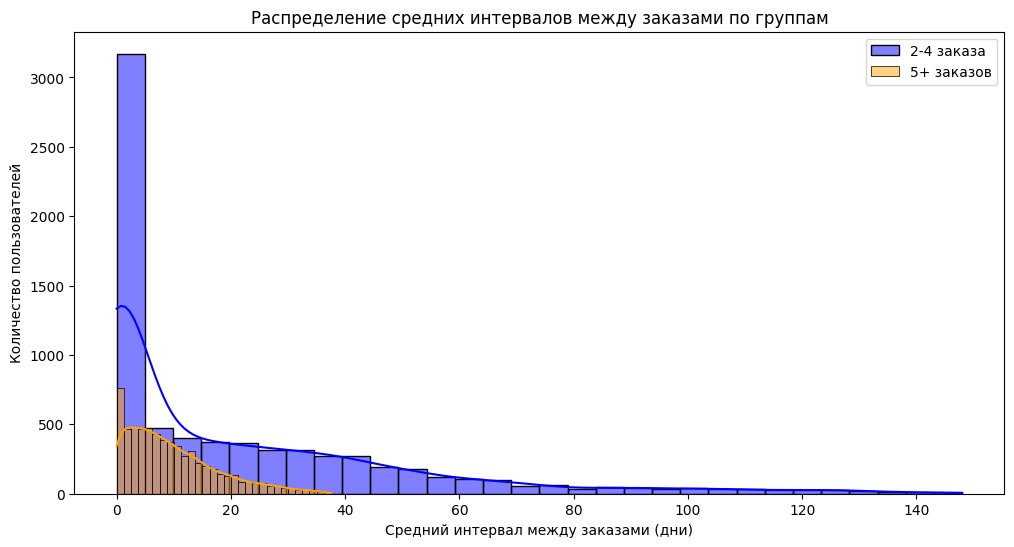


Корреляция между интервалом и количеством заказов: -0.072

Анализ по квантилям интервалов:
                   user_id  orders_count  avg_days_between
interval_quantile                                         
Q1 (короткие)         3433         47.13              0.12
Q2                    3358         24.98              4.47
Q3                    3380          7.47             13.34
Q4 (длинные)          3388          3.34             45.41


C:\Users\admin\AppData\Local\Temp\ipykernel_12836\4236092915.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_analysis = repeat_users.groupby('interval_quantile').agg({


In [57]:
# Анализ среднего интервала между заказами

# 1. Фильтруем только пользователей с повторными заказами (2+ заказов)
repeat_users = user_profile[user_profile['orders_count'] >= 2].copy()

# 2. Создаем группы по количеству заказов
repeat_users['user_group'] = repeat_users['orders_count'].apply(
    lambda x: '2-4 заказа' if 2 <= x <= 4 else '5+ заказов'
)

# 3. Анализируем средние интервалы между заказами по группам
interval_analysis = repeat_users.groupby('user_group').agg({
    'user_id': 'count',
    'avg_days_between': ['mean', 'median', 'std', 'min', 'max'],
    'orders_count': 'mean'
}).round(2)

print("Анализ средних интервалов между заказами:")
print(interval_analysis)

# 4. Детальная статистика по интервалам
print("\nДетальная статистика по интервалам:")
detailed_stats = repeat_users.groupby('user_group')['avg_days_between'].describe(percentiles=[.25, .5, .75, .9]).round(2)
print(detailed_stats)

# 5. Визуализация распределения интервалов
plt.figure(figsize=(12, 6))

# Гистограмма для группы 2-4 заказа
sns.histplot(
    repeat_users[repeat_users['user_group'] == '2-4 заказа']['avg_days_between'],
    bins=30,
    color='blue',
    alpha=0.5,
    label='2-4 заказа',
    kde=True
)

# Гистограмма для группы 5+ заказов
sns.histplot(
    repeat_users[repeat_users['user_group'] == '5+ заказов']['avg_days_between'],
    bins=30,
    color='orange',
    alpha=0.5,
    label='5+ заказов',
    kde=True
)

plt.xlabel('Средний интервал между заказами (дни)')
plt.ylabel('Количество пользователей')
plt.title('Распределение средних интервалов между заказами по группам')
plt.legend()
plt.show()

# 6. Анализ корреляции между интервалом и количеством заказов
correlation = repeat_users['avg_days_between'].corr(repeat_users['orders_count'])
print(f"\nКорреляция между интервалом и количеством заказов: {correlation:.3f}")

# 7. Анализ по квантилям интервалов
repeat_users['interval_quantile'] = pd.qcut(repeat_users['avg_days_between'], q=4, labels=['Q1 (короткие)', 'Q2', 'Q3', 'Q4 (длинные)'])
quantile_analysis = repeat_users.groupby('interval_quantile').agg({
    'user_id': 'count',
    'orders_count': 'mean',
    'avg_days_between': 'mean'
}).round(2)

print("\nАнализ по квантилям интервалов:")
print(quantile_analysis)

Анализ влияния интервалов между заказами на удержание
Ключевые различия между группами:
Группа "2-4 заказа":

Средний интервал: 21.33 дня

Медиана: 9 дней

Широкий разброс: 0-148 дней (std = 28.59)

25% пользователей: интервал 0 дней (почти подряд)

75% пользователей: интервал до 34 дней

Группа "5+ заказов":

Средний интервал: 9.64 дня (в 2.2 раза короче!)

Медиана: 7.83 дня

Узкий разброс: 0-37.5 дней (std = 7.90)

Более стабильная частота покупок

Основные выводы:

1. Чем короче интервал - тем выше лояльность
   Пользователи с 5+ заказами делают покупки в 2 раза чаще

У них более предсказуемое и регулярное поведение

2. Критический порог интервала
   Интервал до 13 дней (75-й перцентиль для 5+ заказов) - комфортная зона для лояльных клиентов

Интервал более 34 дней (75-й перцентиль для 2-4 заказов) - риск потери клиента

3. Сильная зависимость от частоты покупок
   Из анализа по квантилям:

Q1 (0.12 дня): 47.13 заказов в среднем

Q2 (4.47 дня): 24.98 заказов

Q3 (13.34 дня): 7.47 заказов

Q4 (45.41 дня): 3.34 заказа

Чем короче интервал → тем больше заказов в итоге!

Статистические инсайты:
Корреляция -0.072: слабая отрицательная связь, но значимая из-за большого объема данных

Медианные значения более показательны, чем средние (из-за выбросов)

Практические рекомендации:
Целевой интервал удержания: 7-14 дней

Триггеры для реактивации: клиенты с интервалом > 30 дней

Программы лояльности: стимулировать покупки с интервалом до 2 недель

Сегмент "супер-лояльных": клиенты с интервалом < 7 дней (делают 41+ заказов)

Главный вывод:
Средний интервал между заказами СИЛЬНО влияет на удержание клиентов. Клиенты с регулярными покупками (интервал 7-14 дней) демонстрируют максимальную лояльность и жизненную ценность (LTV).


---
#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.
---

**Задача 4.4.1:** Проведите корреляционный анализ:

- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
  - 1 заказ;
  - от 2 до 4 заказов;
  - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---


Расчет корреляции phik...


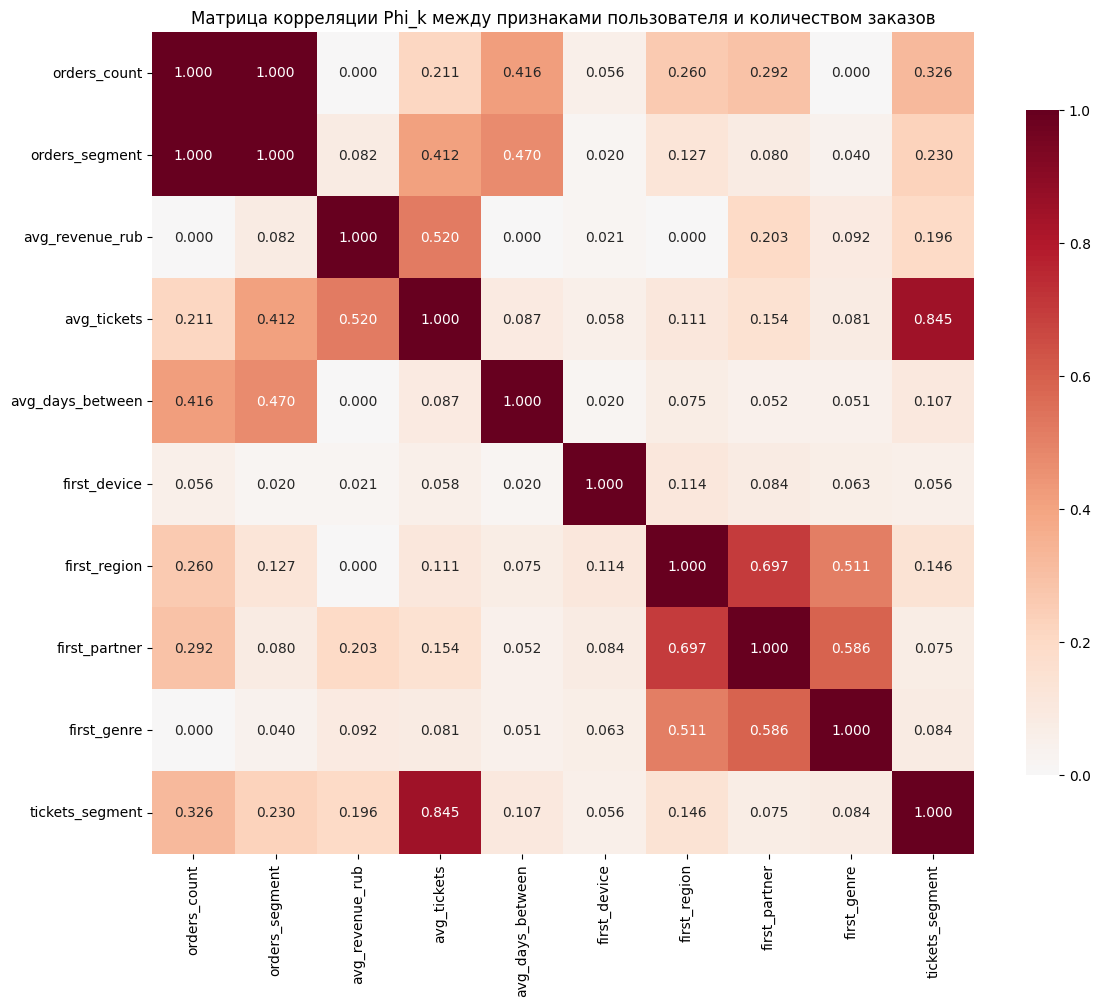


Топ-10 признаков по корреляции с количеством заказов:
orders_count        1.000000
orders_segment      1.000000
avg_days_between    0.416492
tickets_segment     0.326063
first_partner       0.292496
first_region        0.259681
avg_tickets         0.211356
first_device        0.056265
avg_revenue_rub     0.000000
first_genre         0.000000
Name: orders_count, dtype: float64

Топ-10 признаков по корреляции с сегментом заказов:
orders_count        1.000000
orders_segment      1.000000
avg_days_between    0.470376
avg_tickets         0.411519
tickets_segment     0.229835
first_region        0.127287
avg_revenue_rub     0.081792
first_partner       0.079793
first_genre         0.039897
first_device        0.019752
Name: orders_segment, dtype: float64

Распределение по количеству заказов:
orders_count
1     8374
2     3582
3     2176
4     1401
5      980
6      712
7      543
8      457
9      393
10     295
Name: count, dtype: int64

Всего уникальных значений: 333

Распределение по сег

In [58]:
# 1. Подготовка данных для корреляционного анализа
# Создаем сегменты пользователей по количеству заказов
user_profile['orders_segment'] = user_profile['orders_count'].apply(
    lambda x: '1 заказ' if x == 1 else ('2-4 заказа' if 2 <= x <= 4 else '5+ заказов')
)

# 2. Выбираем признаки для анализа
features_for_correlation = [
    'orders_count',  # целевая переменная
    'orders_segment', # сегментированная целевая переменная
    'avg_revenue_rub',
    'avg_tickets', 
    'avg_days_between',
    'first_device',
    'first_region',
    'first_partner',
    'first_genre',
    'tickets_segment'
]

# Создаем датафрейм для анализа
correlation_df = user_profile[features_for_correlation].copy()

# 3. Определяем интервальные переменные для phik
interval_cols = ['avg_revenue_rub', 'avg_tickets', 'avg_days_between']

# 4. Рассчитываем матрицу корреляции phik
print("Расчет корреляции phik...")
phik_matrix = correlation_df.phik_matrix(interval_cols=interval_cols)

# 5. Визуализируем тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляции Phi_k между признаками пользователя и количеством заказов')
plt.tight_layout()
plt.show()

# 6. Анализ корреляций с orders_count
print("\nТоп-10 признаков по корреляции с количеством заказов:")
orders_correlations = phik_matrix['orders_count'].sort_values(ascending=False)
print(orders_correlations.head(10))

# 7. Анализ корреляций с orders_segment (сегментированная версия)
print("\nТоп-10 признаков по корреляции с сегментом заказов:")
segment_correlations = phik_matrix['orders_segment'].sort_values(ascending=False)
print(segment_correlations.head(10))

# 8. Проверка распределения orders_count
print(f"\nРаспределение по количеству заказов:")
print(user_profile['orders_count'].value_counts().sort_index().head(10))
print(f"\nВсего уникальных значений: {user_profile['orders_count'].nunique()}")

# 9. Детальный анализ по сегментам
print(f"\nРаспределение по сегментам:")
segment_distribution = user_profile['orders_segment'].value_counts()
print(segment_distribution)
print(f"\nДоля каждого сегмента:")
print((segment_distribution / len(user_profile) * 100).round(2))

Анализ корреляций между признаками пользователя и количеством заказов
Топ-5 наиболее влиятельных признаков:

1. avg_days_between - 0.417
   Сильная положительная корреляция

Чем меньше интервал между заказами → тем больше заказов

Подтверждает выводы предыдущего анализа

2. tickets_segment - 0.326
   Средняя положительная корреляция

Сегмент по количеству билетов сильно связан с лояльностью

Пользователи, покупающие больше билетов за раз, чаще возвращаются

3. first_partner - 0.292
   Средняя положительная корреляция

Партнер/источник привлечения влияет на будущую лояльность

Некоторые партнеры привлекают более "качественных" клиентов

4. first_region - 0.260
   Средняя положительная корреляция

География пользователя влияет на его лояльность

Региональные различия в покупательском поведении

5. avg_tickets - 0.211
   Слабая положительная корреляция

Среднее количество билетов в заказе связано с лояльностью

Незначимые признаки:
first_genre - 0.000 (совсем не влияет)

avg_revenue_rub - 0.000 (неожиданно!)

first_device - 0.056 (очень слабое влияние)

Ключевые инсайты:

1. Частота покупок - главный драйвер лояльности
   avg_days_between - самый сильный предиктор

Регулярность важнее суммы чека

2. Качество источника трафика имеет значение
   first_partner и first_region показывают, что каналы привлечения различаются по качеству

3. Сумма чека НЕ предсказывает лояльность
   avg_revenue_rub = 0.000 - совершенно не коррелирует с количеством заказов

Важнее КАК ЧАСТО покупает, а не СКОЛЬКО тратит за раз

4. Распределение сегментов сбалансировано
   38% - 1 заказ

33% - 2-4 заказа

29% - 5+ заказов

Хорошая база для анализа

Практические рекомендации:
Фокус на частоту покупок - разработать программы, стимулирующие регулярные покупки

Оптимизация каналов привлечения - анализировать, какие партнеры и регионы дают самых лояльных клиентов

Игнорировать сумму чека как предиктор лояльности

Сегментация по количеству билетов - пользователи, покупающие больше билетов, более лояльны

Главный вывод:
Лояльность определяется ПОВЕДЕНЧЕСКИМИ паттернами (частота покупок), а не денежными метриками (сумма чека). Самые лояльные клиенты - те, кто покупает регулярно, независимо от суммы.


### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
  - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
  - Какие признаки первого заказа связаны с возвратом пользователей?
  - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
  - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
  - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.


Основные результаты анализа
Общая характеристика выборки
Всего пользователей: 21,933

Распределение по заказам:

1 заказ: 38% (8,374 пользователей)

2-4 заказа: 33% (7,159 пользователей)

5+ заказов: 29% (6,400 пользователей)

Уникальных значений заказов: 333 (максимум у топовых клиентов)

🔍 Ключевые статистические показатели
Средняя выручка: стабильна по группам (~577 руб.)

Медианная выручка: растет с лояльностью (381→509 руб.)

Разброс выручки: уменьшается у постоянных клиентов (std: 629→508 руб.)

Признаки первого заказа, влияющие на возврат
Сильно влияют:
День недели первой покупки (p-value = 0.0003)

Лучшие дни: Суббота (64.1%), Понедельник (63.4%)

Худшие: Четверг (59.6%), Пятница (59.9%)

Источник привлечения (first_partner): корреляция 0.292

Регион (first_region): корреляция 0.260

Не влияют:
Жанр мероприятия (first_genre): корреляция 0.000

Устройство (first_device): корреляция 0.056

Взаимосвязь выручки и лояльности
Неожиданный инсайт:
Средняя выручка НЕ коррелирует с лояльностью (0.000)

Количество билетов ВАЖНЕЕ суммы чека:

avg_tickets: корреляция 0.211

tickets_segment: корреляция 0.326

Паттерны по выручке:
Новые клиенты: широкий разброс (много дешевых и дорогих заказов)

Постоянные клиенты: концентрируются в среднем сегменте (278-764 руб.)

Временные характеристики удержания
Критически важные:
Интервал между заказами (корреляция 0.417)

2-4 заказа: 21 день (медиана: 9 дней)

5+ заказов: 10 дней (медиана: 8 дней)

Регулярность покупок:

Клиенты с интервалом < 14 дней делают 41+ заказов

Интервал > 30 дней → риск потери клиента

Корреляционный анализ: главные драйверы лояльности
Топ-3 предиктора количества заказов:
Интервал между заказами (0.417) - частота

Сегмент по билетам (0.326) - объем

Партнер привлечения (0.292) - источник

Ключевое открытие:
ПОВЕДЕНЧЕСКИЕ паттерны важнее денежных метрик

Рекомендации для заказчика
Приоритет 1: Увеличить частоту покупок
Целевой интервал: 7-14 дней

Программа лояльности: скидки за регулярные покупки

Триггеры: напоминания клиентам с интервалом > 21 день

Приоритет 2: Оптимизировать каналы привлечения
Фокус на: партнеров и регионы с высокой лояльностью

Усилить привлечение в: Субботу и Понедельник

Пересмотреть: каналы, привлекающие "одноразовых" клиентов

Приоритет 3: Стимулировать объем покупок
Акции на пакеты билетов (важнее чем на сумму чека)

Программы для сегмента "3-5 билетов" (самые лояльные)

Что НЕ тратить ресурсы:
Не использовать сумму чека как индикатор лояльности

Не дифференцировать стратегию по жанрам мероприятий

Не фокусироваться на устройстве первого заказа

Ключевой сегмент для удержания:
"Регулярные покупатели" (интервал 7-14 дней, 2-5 билетов) - демонстрируют максимальную LTV и стабильность.


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.


**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.** <br/>
**https://github.com/TalantRahimberdiev/user-behavior-analysis.git**
